# Munsflow

Munslow (Zamborn, 1995) and Zwamborn et al. (1995) simulations flow through a thick unsaturated percolation zone by convolution.
The convolution (impulse response) is made possible by linearizing the Richards equation governing vertical unsaturated flow. The linearization is done by taking the vertical moisture flow velocity V=dK(theta)/dtheta and the diffusivity D = K(theta)/(dtheta/dpsi) constant.

The soil relations are in Module soils.src.NL_soils, which contains the entire Dutch Staringreeks (36 standard Dutch soils). The soil class also contains the code for the impulse response, the step response and the block response.

Notebook to run the "Munsflow".

Munsflow is an application that simulates percolation through thick unsaturaed zones applying the linearized advection-diffusion equation. The unsaturated flow equations being strongly non-linear, this can only work in situaions where the moisture content is largely constant (varies little), so that the conductivity and the diffusivity may be considered constant and equal to the average situation. It is believed by many to be the case in thick unsaturated percolation zones like in the Veluwe and other high-elevation sandy areas. Thick percolation zones may start with thicknesses beyond say 5 m, in which the travel time for water leaving the rootzone is in th order of weeks or months. The Munsflow idea is use of the linearized AD equation, which then allows defining a unique impulse response, step respons and block response, with which one can compute the downrd flux at any depth of the percolation zone by convolution.

* Zwamborn (1995) Kiwa-SWI report. MSc by Zwamborn at Wageningen University.
* Zwamborn, Athmer and Maas (1995) H2O.

@TO 2025-10-05


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.integrate import simpson
from pathlib import Path
import etc
from soils.src.NL_soils import Soil
from root_zone.src.root_zone_model import get_deBilt_recharge
from src.Munsflow import simulate_munsflow

## Basics

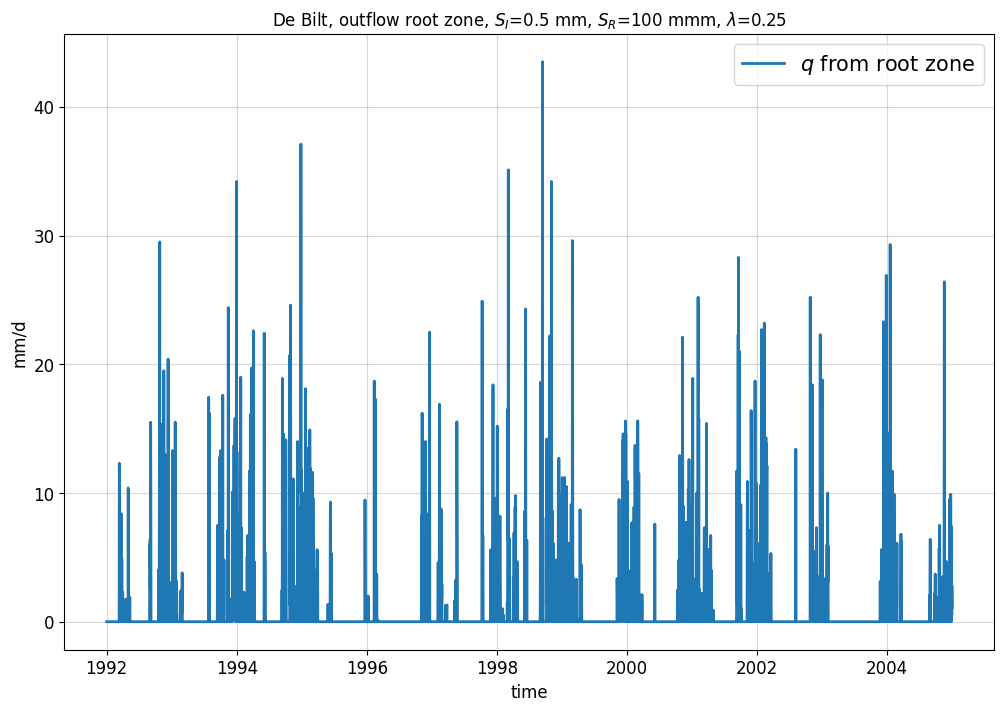

In [3]:
image_folder = os.path.join(Path("__file__").resolve().parent, 'images')

mmpcm = 10 # mm per cm

# --- Choose a soil from the Staringreeks (Dutch standard soil series)        
soil = Soil('O05')

#  --- get recharge data
meteo = get_deBilt_recharge(Smax_I=0.5, Smax_R=100, lam=0.25,
                            datespan=("1992-01-01", "2012-01-01"))

# %% --- show the recharge for De Bilt

ax = etc.newfig(r"De Bilt, outflow root zone, $S_I$=0.5 mm, $S_R$=100 mmm, $\lambda$=0.25", "time", "mm/d")
mask = np.logical_and(meteo.index >= np.datetime64("1990-01-01"), meteo.index <= np.datetime64("2005-01-01"))
ax.plot(meteo.index[mask], meteo.loc[mask, 'RCH'], label=r'$q$ from root zone')
ax.grid(True)
ax.legend()

ax.figure.savefig(os.path.join(image_folder, "q_fr_root_zone.png"))

## Compute and show step and impulse responses according to Munsflow

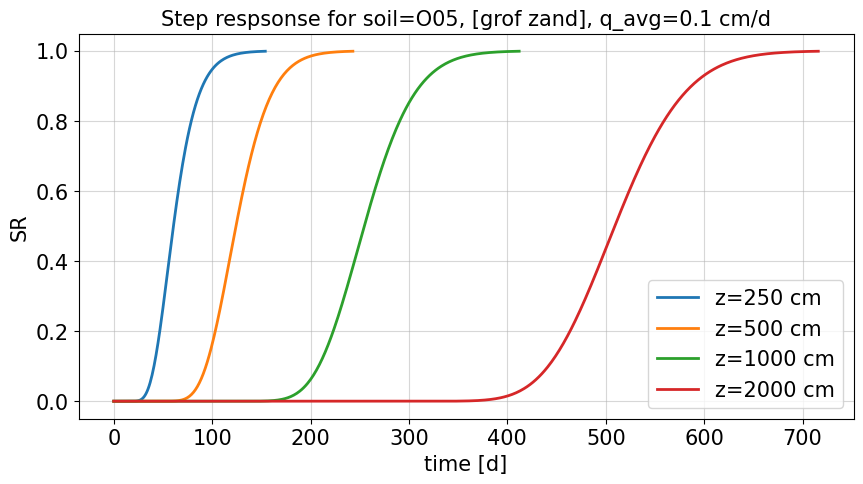

In [15]:
# --- Convert the meteo to a uniform values of 1 mm/d
q_avg_cm = 1 * meteo['RCH'].mean() / 10. # cm/d

# --- Get the index as a floating point time
tau = np.asarray(meteo.index - meteo.index[0]) / np.timedelta64(1, 'D')

# --- Prevent division by zero error
tau[0] = 1e-6


# --- Compute and show the step, block and impulse responses ====

# --- specify the cases
zs = [250, 500., 1000., 2000.]
BR, IR, SR, q = dict(), dict(), dict(), dict()

q_avg_cm = 0.1

title=f"Step respsonse for soil={soil.code}, [{soil.props['Omschrijving']}], q_avg={q_avg_cm} cm/d"
ax = etc.newfig(title, "time [d]", "SR", figsize=(10, 5), fontsize=15)

tau_i = dict()
for i, z in enumerate(zs):    
    SR[i] = soil.SR_erfc(z, tau, q_avg_cm)    
    mask = SR[i] < 0.999
    tau_i[i] = tau[mask]
    SR[i] = SR[i][mask]

    ax.plot(tau_i[i], SR[i], label=f"z={z:.0f} cm")
ax.grid(True)
ax.legend()

ax.figure.savefig(os.path.join(image_folder, f'SR_munsflow_{q_avg_cm * 10:.0f}mmpd'))


## Block and impulse responses

0, volIr=0.99897, volBr=0.99893
1, volIr=0.99897, volBr=0.99894
2, volIr=0.99925, volBr=0.99897
3, volIr=0.99915, volBr=0.99894


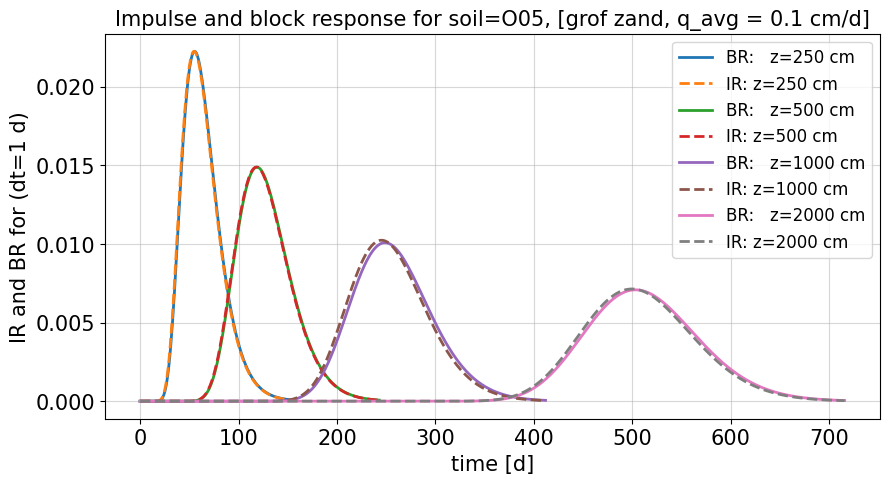

In [16]:
title=f"Impulse and block response for soil={soil.code}, [{soil.props['Omschrijving']}, q_avg = {q_avg_cm} cm/d]"
ax = etc.newfig(title, "time [d]", "IR and BR for (dt=1 d)", figsize=(10, 5), fontsize=15)

zs = [250, 500., 1000., 2000.]

for i, z in enumerate(zs):
    # 
    BR[i] = soil.BR(soil.SR_erfc, z, tau_i[i], q_avg_cm)
    IR[i] = soil.IR(z, tau_i[i], q_avg_cm)
    
    # Check volume below IR
    yBr = BR[i]
    volBr = simpson(BR[i], x=tau_i[i])
    yIr = IR[i]
    volIr = simpson(IR[i], x=tau_i[i])
    print(f"{i}, volIr={volIr:.5f}, volBr={volBr:.5f}")
    

    ax.plot(tau_i[i], BR[i], '-',  label=f"BR:   z={z:.0f} cm")
    ax.plot(tau_i[i], IR[i], '--', label=f"IR: z={z:.0f} cm")
    
ax.grid(True)
ax.legend(fontsize=12)

ax.figure.savefig(os.path.join(image_folder, f'BR_munsflow_{q_avg_cm * 10:.0f}mmpd'))

## Compute the recharge using Munsflow

Running for i=0 ...
z = 250 cm, q = 745 cm, rch =  760 cm
Running for i=1 ...
z = 500.0 cm, q = 739 cm, rch =  760 cm
Running for i=2 ...
z = 1000.0 cm, q = 729 cm, rch =  760 cm
Running for i=3 ...
z = 2000.0 cm, q = 696 cm, rch =  760 cm
... done.


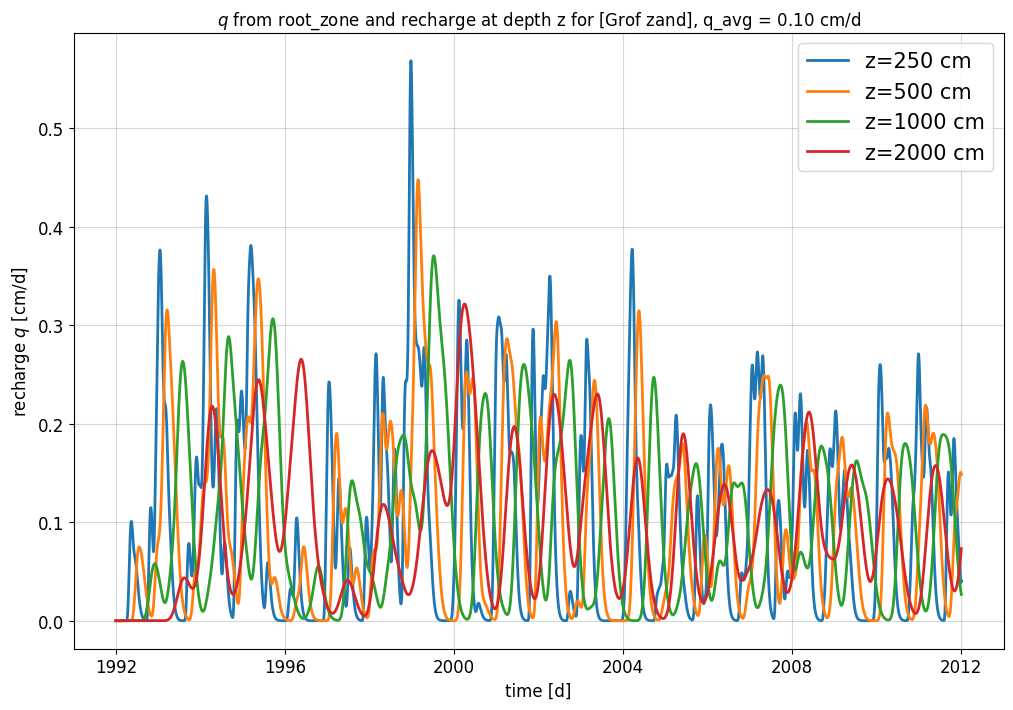

Compare the leakage from the root zone with the recharge at the water table
z = 250 cm, q = 745 cm, rch =  760 cm
z = 500.0 cm, q = 739 cm, rch =  760 cm
z = 1000.0 cm, q = 729 cm, rch =  760 cm
z = 2000.0 cm, q = 696 cm, rch =  760 cm


In [17]:
title=fr"$q$ from root_zone and recharge at depth z for [{soil.props['Omschrijving'].capitalize()}], q_avg = {q_avg_cm:.2f} cm/d"

ax = etc.newfig(title, "time [d]", r"recharge $q$ [cm/d]")

q = dict()

for i, z in enumerate(zs):
    print(f"Running for i={i} ...")
    q[i] = lfilter(BR[i], 1., meteo['RCH'].values / mmpcm)
    ax.plot(meteo.index, q[i], label=f"z={z:.0f} cm")
    print(f"z = {z} cm, q = {q[i].sum():.3g} cm, rch = {meteo['RCH'].sum() / 10.: .3g} cm")
print("... done.")

# ax.set_xlim(np.datetime64("1990-01-01"), np.datetime64("1995-01-01"))
ax.legend(loc='best')
ax.grid(True)
plt.show()

print("Compare the leakage from the root zone with the recharge at the water table")
for i, z in enumerate(zs):    
    print(f"z = {z} cm, q = {q[i].sum():.3g} cm, rch = {meteo['RCH'].sum() / 10.: .3g} cm")

## Simulate ercharge with Munsflow for on case

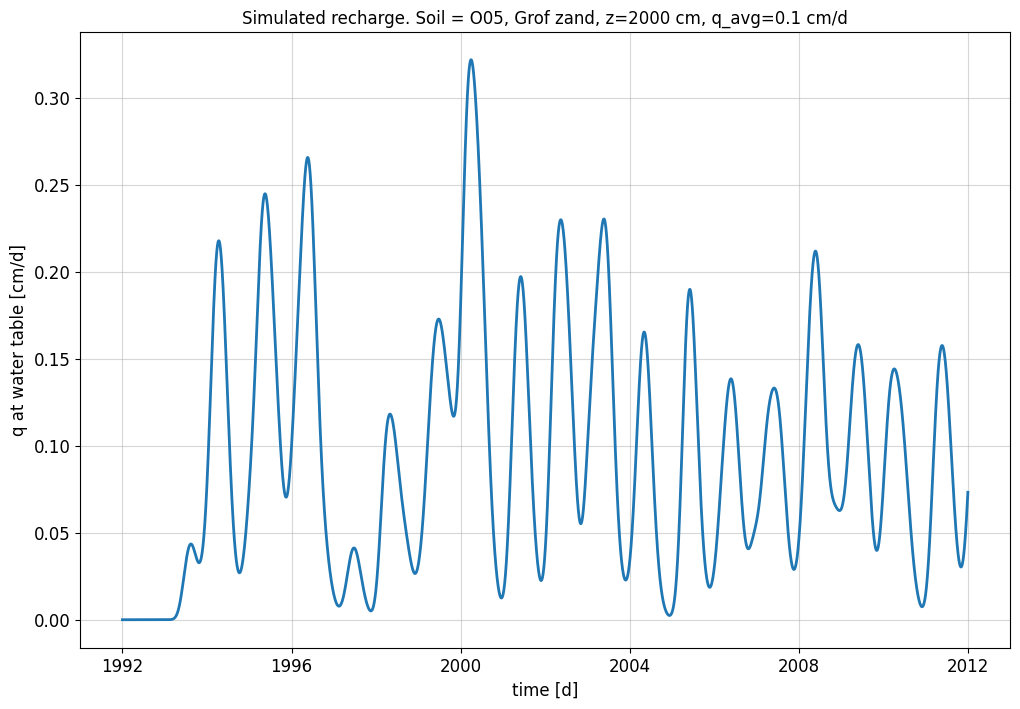

In [18]:
qSeries = simulate_munsflow(meteo=meteo, soil=soil, z=2000, q_avg_cm=0.1)

title = (f"Simulated recharge. Soil = {soil.code}, {soil.props['Omschrijving'].capitalize()}, z={z:.0f} cm, q_avg={q_avg_cm} cm/d")

ax = etc.newfig(title, "time [d]", "q at water table [cm/d]")
ax.plot(qSeries.index, qSeries.values, label=f"recharge at z={z:.0f} cm")

## Show step response for different average flows q_avg

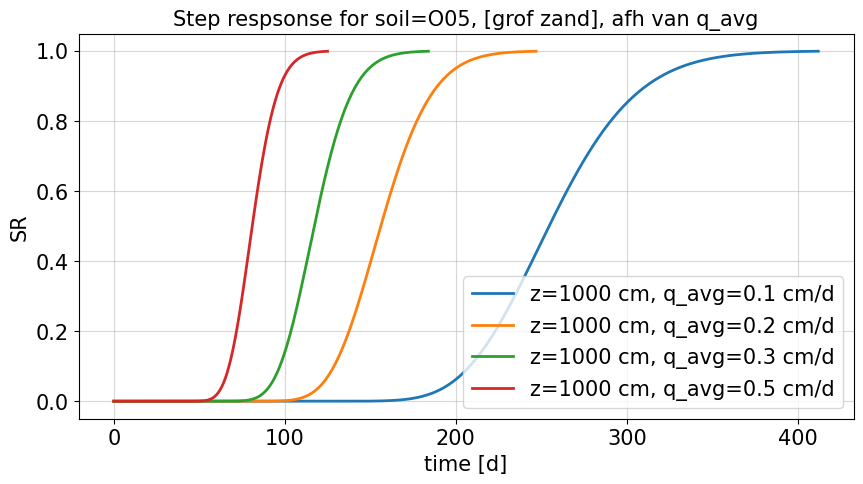

In [19]:
zs = [1000., 1000., 1000., 1000.]
BR, IR, SR, q = dict(), dict(), dict(), dict()

for i, z in enumerate(zs):
    # 
    SR[i] = soil.SR_erfc(z, tau_i[i], q_avg_cm)
    BR[i] = soil.BR(soil.SR_erfc, z, tau_i[i], q_avg_cm)
    IR[i] = soil.IR(z, tau_i[i], q_avg_cm)

q_avg_cms = [0.1, 0.2, 0.3, 0.5]

title=f"Step respsonse for soil={soil.code}, [{soil.props['Omschrijving']}], afh van q_avg"
ax = etc.newfig(title, "time [d]", "SR", figsize=(10, 5), fontsize=15)

tau_i = dict()
for i, (z, qavg) in enumerate(zip(zs, q_avg_cms)):    
    SR[i] = soil.SR_erfc(z, tau, qavg)    
    mask = SR[i] < 0.999
    tau_i[i] = tau[mask]
    SR[i] = SR[i][mask]

    ax.plot(tau_i[i], SR[i], label=f"z={z:.0f} cm, q_avg={qavg:.1f} cm/d")
ax.grid(True)
ax.legend()

ax.figure.savefig(os.path.join(image_folder, 'SR_munsflow_afh_q'))